Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

In [ ]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/wei-tianyu/deep-remote-prior
!mv deep-image-prior/* ./

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'deep-image-prior/*': No such file or directory


In [ ]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 495601617704382170
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3643015452645634615
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

# Import libs

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import time
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data/sr/zebra_GT.png'

# Load image and baselines

HR and LR resolutions: (576, 384), (144, 96)


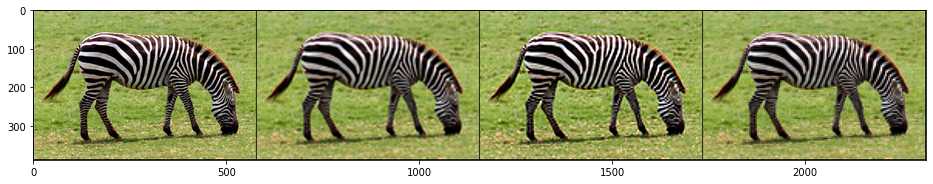

PSNR bicubic: 23.1048   PSNR nearest: 20.8212


In [ ]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['bicubic_np']), 
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['nearest_np'])))

# Set up parameters and net

In [ ]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [ ]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


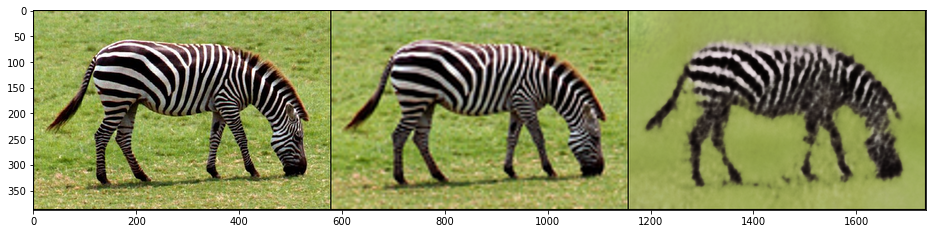

100 runtime: 16.114397764205933
Iteration 00100    Loss 0.011771   psnr_LR: 19.291849   psnr_HR: 17.698426 



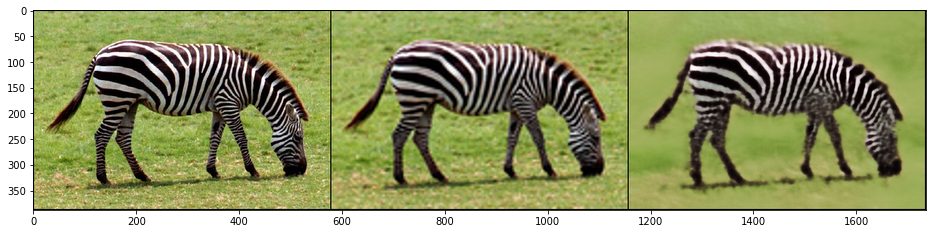

200 runtime: 28.90043306350708
Iteration 00200    Loss 0.004901   psnr_LR: 23.096786   psnr_HR: 20.217905 



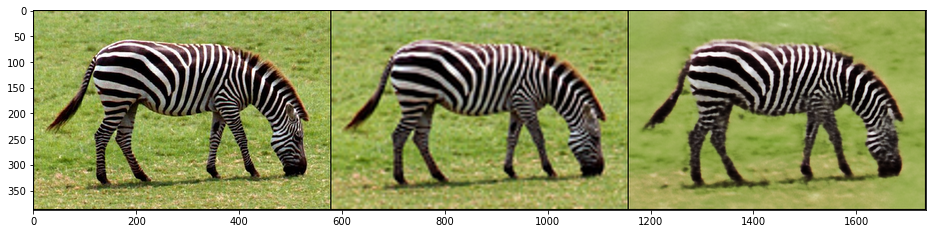

300 runtime: 41.64450025558472
Iteration 00300    Loss 0.003370   psnr_LR: 24.723858   psnr_HR: 21.199140 



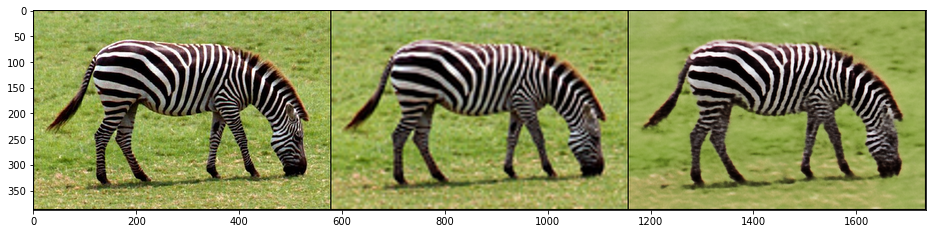

400 runtime: 54.3543541431427
Iteration 00400    Loss 0.002563   psnr_LR: 25.913244   psnr_HR: 21.714294 



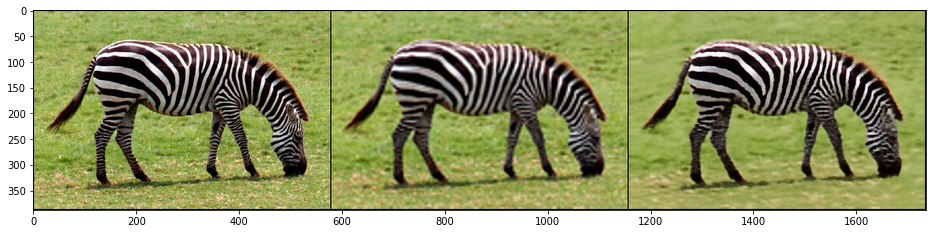

500 runtime: 67.05121684074402
Iteration 00500    Loss 0.002088   psnr_LR: 26.803262   psnr_HR: 22.073295 



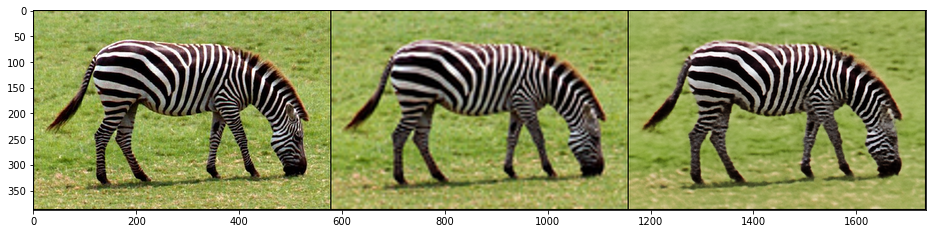

600 runtime: 79.79576706886292
Iteration 00600    Loss 0.001735   psnr_LR: 27.607804   psnr_HR: 22.493449 



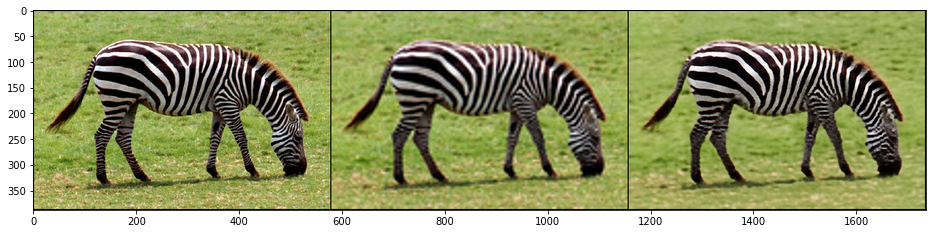

700 runtime: 92.68190312385559
Iteration 00700    Loss 0.001465   psnr_LR: 28.340538   psnr_HR: 22.724383 



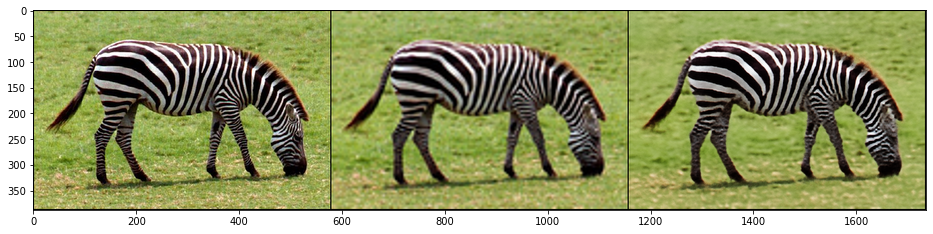

800 runtime: 105.45121049880981
Iteration 00800    Loss 0.001257   psnr_LR: 29.005959   psnr_HR: 22.921662 



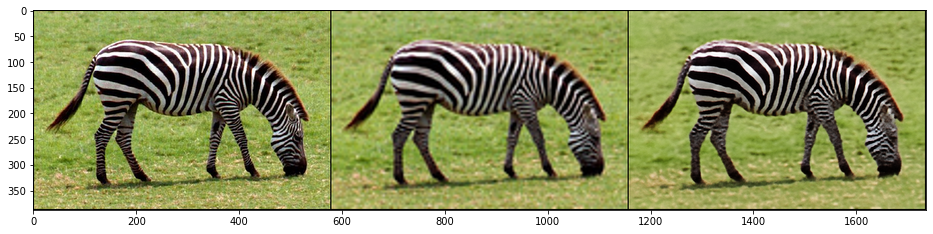

900 runtime: 118.22007822990417
Iteration 00900    Loss 0.001134   psnr_LR: 29.452448   psnr_HR: 23.144741 



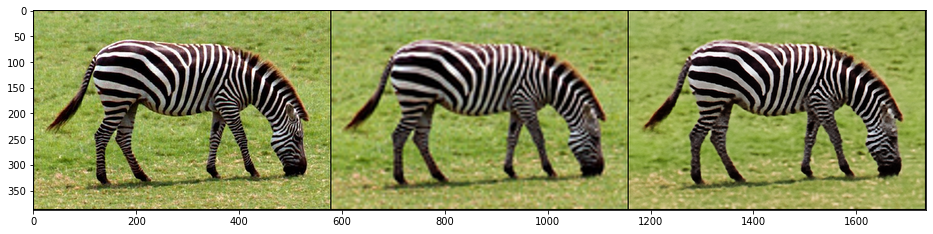

1000 runtime: 130.98315596580505
Iteration 01000    Loss 0.000998   psnr_LR: 30.009569   psnr_HR: 23.329579 



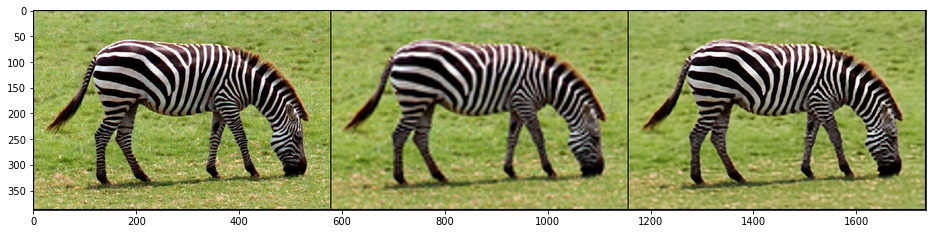

1100 runtime: 143.73792552947998
Iteration 01100    Loss 0.000980   psnr_LR: 30.088521   psnr_HR: 23.238379 



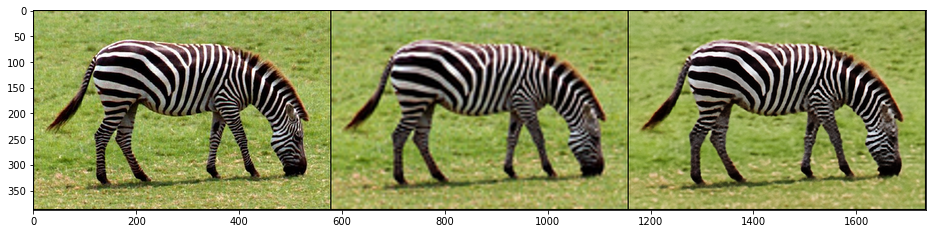

1200 runtime: 156.50199365615845
Iteration 01200    Loss 0.000823   psnr_LR: 30.846537   psnr_HR: 23.507908 



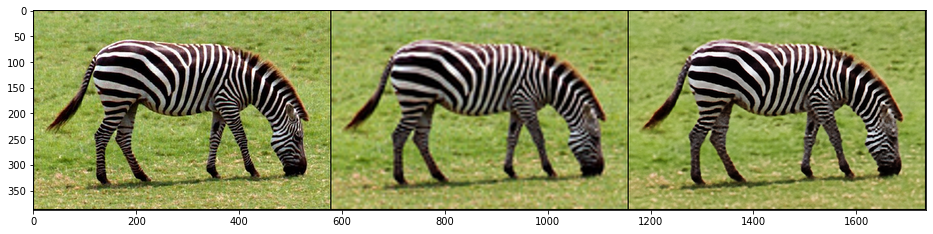

1300 runtime: 169.2272982597351
Iteration 01300    Loss 0.000784   psnr_LR: 31.058834   psnr_HR: 23.611153 



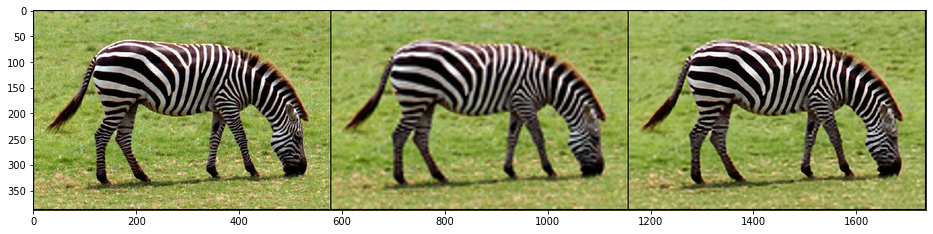

1400 runtime: 181.99831676483154
Iteration 01400    Loss 0.000726   psnr_LR: 31.389356   psnr_HR: 23.701533 



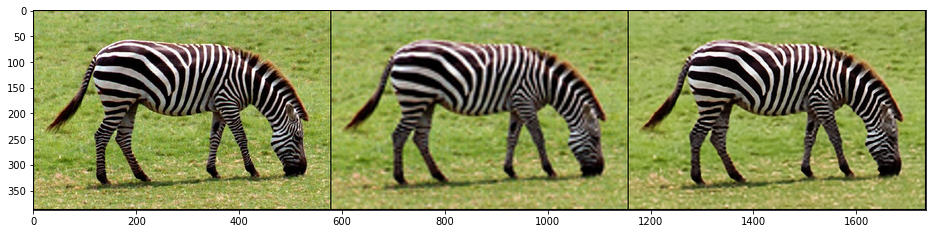

1500 runtime: 194.76794481277466
Iteration 01500    Loss 0.000656   psnr_LR: 31.830021   psnr_HR: 23.808096 



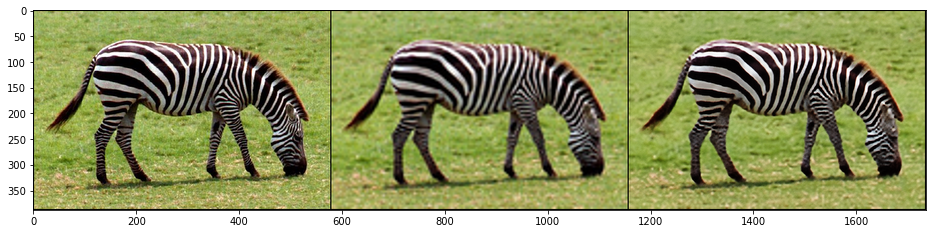

1600 runtime: 207.5389769077301
Iteration 01600    Loss 0.000661   psnr_LR: 31.799849   psnr_HR: 23.674132 



In [ ]:
def closure():
    global i, net_input, start
    if (i == 1):
      start = time.time()
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = peak_signal_noise_ratio(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = peak_signal_noise_ratio(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)
        print (i, "runtime:", time.time() - start)
        print ('Iteration %05d    Loss %f   psnr_LR: %f   psnr_HR: %f' % (i, total_loss.item(), psnr_LR, psnr_HR),'\n')
    i += 1
    
    return total_loss

psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 1
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);

In [ ]:
print(i)